# Paths between BP solutions

Given an instance

- construct a basis $\mathcal{B}=\{v_1,...,v_k\}$ of seaweeds
- find 2 distinct solutions $x_1,x_2$ with BP
- build $x=x_1\oplus x_2$
- find a path of "small" jumps from $0$ to $x$: $x=\alpha^i v_i$
- plot the distortion of of the codeword along the path from $x_1$ to $x_2$

In [1]:
include("../code/bp_full.jl")
include("../code/seaweed.jl")
using OffsetArrays

Build graph and remove some factors

In [13]:
m = factorial(5)*11*4
R = 0.8/3
f3 = 1 - 3R
n = round(Int, 3m/(2+f3))
@show n
Λ = [0,1-f3,f3]
K = [0,0,1]
nedges = 3m
b = round(Int, 3*sqrt(n))

n = 7200


255

In [14]:
Ht = ldpc_matrix(n, m, nedges, Λ, K)
# remove b factors
Ht = Ht[:,1:end-b]
dropzeros!(Ht)
H = sparse(permutedims(copy(Ht)));

### Build two basis using leaf removal

We build two different basis => two sets of independent variables => use them to find 2 different BP solutions

In [15]:
BB1, indep1 = findbasis(H)
@assert iszero(H*BB1.%2)
dim1 = length(indep1)

2175

In [16]:
BB2, indep2 = findbasis(H)
@assert iszero(H*BB2.%2)
dim2 = length(indep2)

2175

### Find 2 BP solutions

In [17]:
# external field strength
HH = 1.3
s = rand((-1,1), n)
efield = [(exp(ss*HH),exp(-ss*HH)) for ss in s]
bp = BPFull(H)
bp.efield .= efield;

In [18]:
bp1 = deepcopy(bp)
bp2 = deepcopy(bp);

In [19]:
nunsat1,_,dist1 = decimate!(bp1, efield, indep1, s;  tol=1e-4, fair_decimation=true, callback=cb_decimation)

Avg distortion after 1st BP round: 0.22223978872787303
 Step    0. Free = 2175. Maxfield = -Inf. ε = 9.02E-01. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    1. Free = 2174. Maxfield = 1.00E+00. ε = 3.05E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    2. Free = 2173. Maxfield = 1.00E+00. ε = 4.81E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    3. Free = 2172. Maxfield = 1.00E+00. ε = 5.49E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    4. Free = 2171. Maxfield = 1.00E+00. ε = 4.82E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    5. Free = 2170. Maxfield = 1.00E+00. ε = 1.01E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    6. Free = 2169. Maxfield = 1.00E+00. ε = 9.07E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    7. Free = 2168. Maxfield = 1.00E+00. ε = 2.37E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    8. Free = 2167. Maxfield = 1.00E+00. ε = 4.58E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    9. Free = 2166. Maxfield = 1.00E+00. ε = 5.07E-04. Unsat = 261. Ovl

 Step   85. Free = 2090. Maxfield = 1.00E+00. ε = 1.97E-02. Unsat = 261. Ovl = 0.623. Iters 1000
 Step   86. Free = 2089. Maxfield = 1.00E+00. ε = 1.69E-02. Unsat = 261. Ovl = 0.623. Iters 1000
 Step   87. Free = 2088. Maxfield = 1.00E+00. ε = 7.30E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step   88. Free = 2087. Maxfield = 1.00E+00. ε = 2.35E-02. Unsat = 261. Ovl = 0.623. Iters 1000
 Step   89. Free = 2086. Maxfield = 1.00E+00. ε = 9.76E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   90. Free = 2085. Maxfield = 1.00E+00. ε = 6.53E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   91. Free = 2084. Maxfield = 1.00E+00. ε = 1.20E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   92. Free = 2083. Maxfield = 1.00E+00. ε = 2.29E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   93. Free = 2082. Maxfield = 1.00E+00. ε = 5.60E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   94. Free = 2081. Maxfield = 1.00E+00. ε = 7.81E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   95. Free = 2080. Maxfi

 Step  171. Free = 2004. Maxfield = 9.99E-01. ε = 7.07E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  172. Free = 2003. Maxfield = 1.00E+00. ε = 7.54E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  173. Free = 2002. Maxfield = 9.99E-01. ε = 1.28E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  174. Free = 2001. Maxfield = 9.99E-01. ε = 6.91E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  175. Free = 2000. Maxfield = 9.99E-01. ε = 7.33E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  176. Free = 1999. Maxfield = 9.99E-01. ε = 7.74E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  177. Free = 1998. Maxfield = 9.99E-01. ε = 1.08E-01. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  178. Free = 1997. Maxfield = 9.99E-01. ε = 5.82E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  179. Free = 1996. Maxfield = 9.99E-01. ε = 6.23E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  180. Free = 1995. Maxfield = 9.99E-01. ε = 2.59E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  181. Free = 1994. Maxfi

 Step  257. Free = 1918. Maxfield = 9.99E-01. ε = 8.11E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  258. Free = 1917. Maxfield = 9.99E-01. ε = 2.56E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  259. Free = 1916. Maxfield = 9.99E-01. ε = 1.33E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  260. Free = 1915. Maxfield = 9.99E-01. ε = 6.91E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  261. Free = 1914. Maxfield = 9.99E-01. ε = 5.89E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  262. Free = 1913. Maxfield = 9.99E-01. ε = 2.05E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  263. Free = 1912. Maxfield = 9.99E-01. ε = 2.80E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  264. Free = 1911. Maxfield = 9.99E-01. ε = 1.13E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  265. Free = 1910. Maxfield = 1.00E+00. ε = 9.28E-01. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  266. Free = 1909. Maxfield = 9.99E-01. ε = 3.11E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  267. Free = 1908. Maxfi

 Step  343. Free = 1832. Maxfield = 9.99E-01. ε = 7.15E-02. Unsat = 257. Ovl = 0.621. Iters 1000
 Step  344. Free = 1831. Maxfield = 9.98E-01. ε = 5.47E-02. Unsat = 257. Ovl = 0.621. Iters 1000
 Step  345. Free = 1830. Maxfield = 9.98E-01. ε = 7.94E-02. Unsat = 257. Ovl = 0.621. Iters 1000
 Step  346. Free = 1829. Maxfield = 9.98E-01. ε = 3.27E-01. Unsat = 256. Ovl = 0.622. Iters 1000
 Step  347. Free = 1828. Maxfield = 9.98E-01. ε = 3.02E-02. Unsat = 256. Ovl = 0.622. Iters 1000
 Step  348. Free = 1827. Maxfield = 9.98E-01. ε = 7.32E-02. Unsat = 254. Ovl = 0.621. Iters 1000
 Step  349. Free = 1826. Maxfield = 9.98E-01. ε = 4.70E-02. Unsat = 254. Ovl = 0.621. Iters 1000
 Step  350. Free = 1825. Maxfield = 1.00E+00. ε = 3.99E-01. Unsat = 254. Ovl = 0.621. Iters 1000
 Step  351. Free = 1824. Maxfield = 9.98E-01. ε = 3.06E-01. Unsat = 256. Ovl = 0.622. Iters 1000
 Step  352. Free = 1823. Maxfield = 9.98E-01. ε = 3.31E-02. Unsat = 256. Ovl = 0.622. Iters 1000
 Step  353. Free = 1822. Maxfi

 Step  429. Free = 1746. Maxfield = 9.97E-01. ε = 1.61E-02. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  430. Free = 1745. Maxfield = 9.97E-01. ε = 2.64E-02. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  431. Free = 1744. Maxfield = 9.97E-01. ε = 8.58E-02. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  432. Free = 1743. Maxfield = 9.97E-01. ε = 1.35E-01. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  433. Free = 1742. Maxfield = 9.97E-01. ε = 4.40E-02. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  434. Free = 1741. Maxfield = 9.97E-01. ε = 1.46E-01. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  435. Free = 1740. Maxfield = 9.97E-01. ε = 1.47E-01. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  436. Free = 1739. Maxfield = 9.97E-01. ε = 1.49E-01. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  437. Free = 1738. Maxfield = 9.97E-01. ε = 5.20E-02. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  438. Free = 1737. Maxfield = 9.97E-01. ε = 2.04E-01. Unsat = 237. Ovl = 0.620. Iters 1000
 Step  439. Free = 1736. Maxfi

 Step  515. Free = 1660. Maxfield = 9.95E-01. ε = 8.14E-02. Unsat = 254. Ovl = 0.623. Iters 1000
 Step  516. Free = 1659. Maxfield = 9.95E-01. ε = 3.97E-02. Unsat = 254. Ovl = 0.623. Iters 1000
 Step  517. Free = 1658. Maxfield = 9.95E-01. ε = 6.06E-02. Unsat = 254. Ovl = 0.623. Iters 1000
 Step  518. Free = 1657. Maxfield = 9.95E-01. ε = 3.52E-02. Unsat = 254. Ovl = 0.623. Iters 1000
 Step  519. Free = 1656. Maxfield = 9.95E-01. ε = 1.21E-01. Unsat = 254. Ovl = 0.623. Iters 1000
 Step  520. Free = 1655. Maxfield = 1.00E+00. ε = 3.16E-01. Unsat = 254. Ovl = 0.623. Iters 1000
 Step  521. Free = 1654. Maxfield = 9.95E-01. ε = 3.93E-02. Unsat = 251. Ovl = 0.623. Iters 1000
 Step  522. Free = 1653. Maxfield = 1.00E+00. ε = 6.20E-01. Unsat = 251. Ovl = 0.623. Iters 1000
 Step  523. Free = 1652. Maxfield = 9.99E-01. ε = 6.20E-01. Unsat = 251. Ovl = 0.623. Iters 1000
 Step  524. Free = 1651. Maxfield = 9.99E-01. ε = 1.64E-01. Unsat = 251. Ovl = 0.623. Iters 1000
 Step  525. Free = 1650. Maxfi

 Step  601. Free = 1574. Maxfield = 9.96E-01. ε = 1.21E-01. Unsat = 242. Ovl = 0.621. Iters 1000
 Step  602. Free = 1573. Maxfield = 9.94E-01. ε = 5.05E-01. Unsat = 242. Ovl = 0.621. Iters 1000
 Step  603. Free = 1572. Maxfield = 9.94E-01. ε = 2.43E-01. Unsat = 242. Ovl = 0.621. Iters 1000
 Step  604. Free = 1571. Maxfield = 9.98E-01. ε = 1.31E-01. Unsat = 242. Ovl = 0.621. Iters 1000
 Step  605. Free = 1570. Maxfield = 9.94E-01. ε = 6.27E-02. Unsat = 242. Ovl = 0.621. Iters 1000
 Step  606. Free = 1569. Maxfield = 9.94E-01. ε = 1.94E-01. Unsat = 240. Ovl = 0.621. Iters 1000
 Step  607. Free = 1568. Maxfield = 9.94E-01. ε = 2.24E-01. Unsat = 240. Ovl = 0.620. Iters 1000
 Step  608. Free = 1567. Maxfield = 9.94E-01. ε = 6.53E-02. Unsat = 240. Ovl = 0.620. Iters 1000
 Step  609. Free = 1566. Maxfield = 9.94E-01. ε = 5.52E-02. Unsat = 240. Ovl = 0.620. Iters 1000
 Step  610. Free = 1565. Maxfield = 9.94E-01. ε = 7.79E-02. Unsat = 240. Ovl = 0.620. Iters 1000
 Step  611. Free = 1564. Maxfi

 Step  687. Free = 1488. Maxfield = 9.98E-01. ε = 1.29E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  688. Free = 1487. Maxfield = 9.91E-01. ε = 1.30E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  689. Free = 1486. Maxfield = 9.91E-01. ε = 6.30E-02. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  690. Free = 1485. Maxfield = 1.00E+00. ε = 1.17E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  691. Free = 1484. Maxfield = 9.91E-01. ε = 1.71E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  692. Free = 1483. Maxfield = 9.91E-01. ε = 6.01E-02. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  693. Free = 1482. Maxfield = 9.91E-01. ε = 7.25E-02. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  694. Free = 1481. Maxfield = 9.92E-01. ε = 4.78E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  695. Free = 1480. Maxfield = 9.91E-01. ε = 1.10E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  696. Free = 1479. Maxfield = 9.91E-01. ε = 1.03E-01. Unsat = 241. Ovl = 0.619. Iters 1000
 Step  697. Free = 1478. Maxfi

 Step  773. Free = 1402. Maxfield = 9.87E-01. ε = 5.60E-02. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  774. Free = 1401. Maxfield = 9.87E-01. ε = 6.64E-02. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  775. Free = 1400. Maxfield = 9.87E-01. ε = 3.10E-02. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  776. Free = 1399. Maxfield = 9.87E-01. ε = 5.77E-02. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  777. Free = 1398. Maxfield = 9.88E-01. ε = 6.15E-01. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  778. Free = 1397. Maxfield = 9.87E-01. ε = 1.02E-01. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  779. Free = 1396. Maxfield = 9.89E-01. ε = 6.03E-01. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  780. Free = 1395. Maxfield = 9.87E-01. ε = 8.37E-02. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  781. Free = 1394. Maxfield = 9.87E-01. ε = 1.41E-01. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  782. Free = 1393. Maxfield = 9.87E-01. ε = 3.07E-01. Unsat = 235. Ovl = 0.617. Iters 1000
 Step  783. Free = 1392. Maxfi

 Step  859. Free = 1316. Maxfield = 9.82E-01. ε = 3.86E-01. Unsat = 225. Ovl = 0.615. Iters 1000
 Step  860. Free = 1315. Maxfield = 9.82E-01. ε = 1.02E-01. Unsat = 225. Ovl = 0.615. Iters 1000
 Step  861. Free = 1314. Maxfield = 9.82E-01. ε = 3.98E-01. Unsat = 225. Ovl = 0.615. Iters 1000
 Step  862. Free = 1313. Maxfield = 1.00E+00. ε = 2.70E-01. Unsat = 225. Ovl = 0.615. Iters 1000
 Step  863. Free = 1312. Maxfield = 9.82E-01. ε = 6.23E-02. Unsat = 225. Ovl = 0.615. Iters 1000
 Step  864. Free = 1311. Maxfield = 9.82E-01. ε = 4.20E-02. Unsat = 225. Ovl = 0.616. Iters 1000
 Step  865. Free = 1310. Maxfield = 9.82E-01. ε = 1.62E-01. Unsat = 226. Ovl = 0.616. Iters 1000
 Step  866. Free = 1309. Maxfield = 9.82E-01. ε = 4.29E-01. Unsat = 227. Ovl = 0.616. Iters 1000
 Step  867. Free = 1308. Maxfield = 9.98E-01. ε = 1.92E-01. Unsat = 227. Ovl = 0.616. Iters 1000
 Step  868. Free = 1307. Maxfield = 9.88E-01. ε = 1.41E-01. Unsat = 225. Ovl = 0.615. Iters 1000
 Step  869. Free = 1306. Maxfi

 Step  945. Free = 1230. Maxfield = 1.00E+00. ε = 1.78E-01. Unsat = 211. Ovl = 0.612. Iters 1000
 Step  946. Free = 1229. Maxfield = 1.00E+00. ε = 1.77E-01. Unsat = 211. Ovl = 0.612. Iters 1000
 Step  947. Free = 1228. Maxfield = 9.79E-01. ε = 6.56E-02. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  948. Free = 1227. Maxfield = 1.00E+00. ε = 3.20E-01. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  949. Free = 1226. Maxfield = 9.79E-01. ε = 4.35E-01. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  950. Free = 1225. Maxfield = 9.97E-01. ε = 2.03E-01. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  951. Free = 1224. Maxfield = 9.79E-01. ε = 7.73E-02. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  952. Free = 1223. Maxfield = 9.79E-01. ε = 2.06E-01. Unsat = 211. Ovl = 0.612. Iters 1000
 Step  953. Free = 1222. Maxfield = 9.78E-01. ε = 2.23E-01. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  954. Free = 1221. Maxfield = 9.87E-01. ε = 3.21E-01. Unsat = 209. Ovl = 0.612. Iters 1000
 Step  955. Free = 1220. Maxfi

 Step  1031. Free = 1144. Maxfield = 9.79E-01. ε = 1.17E-01. Unsat = 182. Ovl = 0.609. Iters 1000
 Step  1032. Free = 1143. Maxfield = 9.79E-01. ε = 2.64E-01. Unsat = 182. Ovl = 0.609. Iters 1000
 Step  1033. Free = 1142. Maxfield = 9.90E-01. ε = 8.55E-01. Unsat = 182. Ovl = 0.609. Iters 1000
 Step  1034. Free = 1141. Maxfield = 9.79E-01. ε = 7.43E-02. Unsat = 181. Ovl = 0.608. Iters 1000
 Step  1035. Free = 1140. Maxfield = 1.00E+00. ε = 5.21E-01. Unsat = 181. Ovl = 0.608. Iters 1000
 Step  1036. Free = 1139. Maxfield = 9.78E-01. ε = 2.35E-01. Unsat = 179. Ovl = 0.608. Iters 1000
 Step  1037. Free = 1138. Maxfield = 9.78E-01. ε = 2.14E-01. Unsat = 179. Ovl = 0.608. Iters 1000
 Step  1038. Free = 1137. Maxfield = 9.78E-01. ε = 1.60E-01. Unsat = 178. Ovl = 0.608. Iters 1000
 Step  1039. Free = 1136. Maxfield = 9.78E-01. ε = 4.58E-01. Unsat = 177. Ovl = 0.607. Iters 1000
 Step  1040. Free = 1135. Maxfield = 1.00E+00. ε = 8.30E-01. Unsat = 177. Ovl = 0.607. Iters 1000
 Step  1041. Free = 

 Step  1115. Free = 1060. Maxfield = 1.00E+00. ε = 6.83E-01. Unsat = 170. Ovl = 0.604. Iters 1000
 Step  1116. Free = 1059. Maxfield = 9.78E-01. ε = 3.51E-01. Unsat = 171. Ovl = 0.605. Iters 1000
 Step  1117. Free = 1058. Maxfield = 9.78E-01. ε = 3.20E-01. Unsat = 171. Ovl = 0.605. Iters 1000
 Step  1118. Free = 1057. Maxfield = 9.96E-01. ε = 4.20E-01. Unsat = 171. Ovl = 0.605. Iters 1000
 Step  1119. Free = 1056. Maxfield = 9.77E-01. ε = 6.53E-02. Unsat = 171. Ovl = 0.605. Iters 1000
 Step  1120. Free = 1055. Maxfield = 9.77E-01. ε = 5.28E-01. Unsat = 173. Ovl = 0.605. Iters 1000
 Step  1121. Free = 1054. Maxfield = 9.80E-01. ε = 1.37E-01. Unsat = 174. Ovl = 0.605. Iters 1000
 Step  1122. Free = 1053. Maxfield = 9.96E-01. ε = 6.82E-01. Unsat = 171. Ovl = 0.604. Iters 1000
 Step  1123. Free = 1052. Maxfield = 9.93E-01. ε = 9.67E-01. Unsat = 171. Ovl = 0.605. Iters 1000
 Step  1124. Free = 1051. Maxfield = 9.77E-01. ε = 2.41E-01. Unsat = 166. Ovl = 0.603. Iters 1000
 Step  1125. Free = 

 Step  1199. Free = 976. Maxfield = 9.79E-01. ε = 4.23E-01. Unsat = 164. Ovl = 0.602. Iters 1000
 Step  1200. Free = 975. Maxfield = 9.77E-01. ε = 1.89E-01. Unsat = 162. Ovl = 0.601. Iters 1000
 Step  1201. Free = 974. Maxfield = 9.77E-01. ε = 1.63E-01. Unsat = 162. Ovl = 0.601. Iters 1000
 Step  1202. Free = 973. Maxfield = 9.86E-01. ε = 2.13E-01. Unsat = 162. Ovl = 0.601. Iters 1000
 Step  1203. Free = 972. Maxfield = 9.91E-01. ε = 4.02E-01. Unsat = 162. Ovl = 0.601. Iters 1000
 Step  1204. Free = 971. Maxfield = 9.78E-01. ε = 5.77E-01. Unsat = 159. Ovl = 0.601. Iters 1000
 Step  1205. Free = 970. Maxfield = 9.99E-01. ε = 4.34E-01. Unsat = 159. Ovl = 0.601. Iters 1000
 Step  1206. Free = 969. Maxfield = 9.83E-01. ε = 1.51E-01. Unsat = 159. Ovl = 0.601. Iters 1000
 Step  1207. Free = 968. Maxfield = 9.86E-01. ε = 2.98E-01. Unsat = 160. Ovl = 0.601. Iters 1000
 Step  1208. Free = 967. Maxfield = 9.97E-01. ε = 6.13E-01. Unsat = 160. Ovl = 0.601. Iters 1000
 Step  1209. Free = 966. Maxfi

 Step  1285. Free = 890. Maxfield = 9.79E-01. ε = 9.55E-01. Unsat = 145. Ovl = 0.596. Iters 1000
 Step  1286. Free = 889. Maxfield = 9.71E-01. ε = 4.20E-01. Unsat = 147. Ovl = 0.597. Iters 1000
 Step  1287. Free = 888. Maxfield = 9.71E-01. ε = 9.29E-01. Unsat = 147. Ovl = 0.597. Iters 1000
 Step  1288. Free = 887. Maxfield = 9.70E-01. ε = 2.44E-01. Unsat = 146. Ovl = 0.597. Iters 1000
 Step  1289. Free = 886. Maxfield = 1.00E+00. ε = 5.58E-01. Unsat = 146. Ovl = 0.597. Iters 1000
 Step  1290. Free = 885. Maxfield = 9.70E-01. ε = 2.35E-01. Unsat = 146. Ovl = 0.597. Iters 1000
 Step  1291. Free = 884. Maxfield = 9.70E-01. ε = 4.70E-01. Unsat = 146. Ovl = 0.597. Iters 1000
 Step  1292. Free = 883. Maxfield = 9.70E-01. ε = 8.87E-01. Unsat = 146. Ovl = 0.597. Iters 1000
 Step  1293. Free = 882. Maxfield = 9.70E-01. ε = 8.95E-01. Unsat = 145. Ovl = 0.597. Iters 1000
 Step  1294. Free = 881. Maxfield = 9.75E-01. ε = 2.09E-01. Unsat = 145. Ovl = 0.597. Iters 1000
 Step  1295. Free = 880. Maxfi

 Step  1371. Free = 804. Maxfield = 9.66E-01. ε = 7.46E-01. Unsat = 146. Ovl = 0.596. Iters 1000
 Step  1372. Free = 803. Maxfield = 9.97E-01. ε = 4.42E-01. Unsat = 146. Ovl = 0.596. Iters 1000
 Step  1373. Free = 802. Maxfield = 9.83E-01. ε = 6.86E-01. Unsat = 146. Ovl = 0.596. Iters 1000
 Step  1374. Free = 801. Maxfield = 9.66E-01. ε = 6.91E-02. Unsat = 145. Ovl = 0.596. Iters 1000
 Step  1375. Free = 800. Maxfield = 9.65E-01. ε = 2.00E-01. Unsat = 141. Ovl = 0.595. Iters 1000
 Step  1376. Free = 799. Maxfield = 9.98E-01. ε = 7.72E-01. Unsat = 141. Ovl = 0.595. Iters 1000
 Step  1377. Free = 798. Maxfield = 9.67E-01. ε = 3.05E-01. Unsat = 146. Ovl = 0.595. Iters 1000
 Step  1378. Free = 797. Maxfield = 9.65E-01. ε = 3.29E-01. Unsat = 144. Ovl = 0.595. Iters 1000
 Step  1379. Free = 796. Maxfield = 9.65E-01. ε = 3.61E-01. Unsat = 144. Ovl = 0.595. Iters 1000
 Step  1380. Free = 795. Maxfield = 9.65E-01. ε = 3.30E-01. Unsat = 144. Ovl = 0.595. Iters 1000
 Step  1381. Free = 794. Maxfi

 Step  1457. Free = 718. Maxfield = 9.98E-01. ε = 7.42E-01. Unsat = 114. Ovl = 0.589. Iters 1000
 Step  1458. Free = 717. Maxfield = 9.61E-01. ε = 7.38E-02. Unsat = 112. Ovl = 0.589. Iters 1000
 Step  1459. Free = 716. Maxfield = 1.00E+00. ε = 3.33E-01. Unsat = 112. Ovl = 0.589. Iters 1000
 Step  1460. Free = 715. Maxfield = 9.99E-01. ε = 7.81E-01. Unsat = 112. Ovl = 0.589. Iters 1000
 Step  1461. Free = 714. Maxfield = 9.58E-01. ε = 3.49E-01. Unsat = 116. Ovl = 0.589. Iters 1000
 Step  1462. Free = 713. Maxfield = 9.85E-01. ε = 6.97E-01. Unsat = 118. Ovl = 0.589. Iters 1000
 Step  1463. Free = 712. Maxfield = 9.58E-01. ε = 8.27E-01. Unsat = 116. Ovl = 0.589. Iters 1000
 Step  1464. Free = 711. Maxfield = 9.57E-01. ε = 1.55E-01. Unsat = 116. Ovl = 0.589. Iters 1000
 Step  1465. Free = 710. Maxfield = 9.55E-01. ε = 3.86E-01. Unsat = 113. Ovl = 0.588. Iters 1000
 Step  1466. Free = 709. Maxfield = 9.55E-01. ε = 7.27E-02. Unsat = 113. Ovl = 0.588. Iters 1000
 Step  1467. Free = 708. Maxfi

 Step  1543. Free = 632. Maxfield = 1.00E+00. ε = 4.27E-01. Unsat = 139. Ovl = 0.584. Iters 1000
 Step  1544. Free = 631. Maxfield = 1.00E+00. ε = 8.39E-01. Unsat = 146. Ovl = 0.584. Iters 1000
 Step  1545. Free = 630. Maxfield = 1.00E+00. ε = 4.12E-01. Unsat = 151. Ovl = 0.588. Iters 1000
 Step  1546. Free = 629. Maxfield = 9.99E-01. ε = 4.09E-01. Unsat = 137. Ovl = 0.584. Iters 1000
 Step  1547. Free = 628. Maxfield = 9.93E-01. ε = 4.07E-01. Unsat = 148. Ovl = 0.583. Iters 1000
 Step  1548. Free = 627. Maxfield = 1.00E+00. ε = 9.15E-01. Unsat = 134. Ovl = 0.589. Iters 1000
 Step  1549. Free = 626. Maxfield = 9.97E-01. ε = 3.87E-01. Unsat = 127. Ovl = 0.586. Iters 1000
 Step  1550. Free = 625. Maxfield = 9.86E-01. ε = 3.65E-01. Unsat = 127. Ovl = 0.584. Iters 1000
 Step  1551. Free = 624. Maxfield = 9.67E-01. ε = 3.57E-01. Unsat = 127. Ovl = 0.587. Iters 1000
 Step  1552. Free = 623. Maxfield = 9.52E-01. ε = 4.98E-01. Unsat = 122. Ovl = 0.588. Iters 1000
 Step  1553. Free = 622. Maxfi

 Step  1629. Free = 546. Maxfield = 1.00E+00. ε = 3.95E-01. Unsat =  87. Ovl = 0.583. Iters 1000
 Step  1630. Free = 545. Maxfield = 9.47E-01. ε = 9.52E-01. Unsat =  89. Ovl = 0.583. Iters 1000
 Step  1631. Free = 544. Maxfield = 1.00E+00. ε = 8.71E-01. Unsat =  89. Ovl = 0.583. Iters 1000
 Step  1632. Free = 543. Maxfield = 9.41E-01. ε = 5.02E-01. Unsat =  89. Ovl = 0.583. Iters 1000
 Step  1633. Free = 542. Maxfield = 9.41E-01. ε = 4.54E-01. Unsat =  89. Ovl = 0.583. Iters 1000
 Step  1634. Free = 541. Maxfield = 9.43E-01. ε = 9.22E-01. Unsat =  88. Ovl = 0.583. Iters 1000
 Step  1635. Free = 540. Maxfield = 9.41E-01. ε = 6.91E-02. Unsat =  88. Ovl = 0.583. Iters 1000
 Step  1636. Free = 539. Maxfield = 9.39E-01. ε = 7.91E-02. Unsat =  86. Ovl = 0.582. Iters 1000
 Step  1637. Free = 538. Maxfield = 9.41E-01. ε = 1.00E+00. Unsat =  76. Ovl = 0.581. Iters 1000
 Step  1638. Free = 537. Maxfield = 1.00E+00. ε = 7.83E-02. Unsat =  76. Ovl = 0.581. Iters 1000
 Step  1639. Free = 536. Maxfi

 Step  1717. Free = 458. Maxfield = 9.31E-01. ε = 6.91E-02. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1718. Free = 457. Maxfield = 9.31E-01. ε = 9.31E-01. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1719. Free = 456. Maxfield = 1.00E+00. ε = 4.99E-01. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1720. Free = 455. Maxfield = 9.31E-01. ε = 5.00E-01. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1721. Free = 454. Maxfield = 9.31E-01. ε = 9.31E-01. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1722. Free = 453. Maxfield = 9.31E-01. ε = 6.91E-02. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1723. Free = 452. Maxfield = 9.31E-01. ε = 6.91E-02. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1724. Free = 451. Maxfield = 9.31E-01. ε = 6.91E-02. Unsat =  62. Ovl = 0.577. Iters 1000
 Step  1725. Free = 450. Maxfield = 9.31E-01. ε = 6.66E-16. Unsat =  62. Ovl = 0.577. Iters 1
 Step  1726. Free = 449. Maxfield = 9.31E-01. ε = 6.66E-16. Unsat =  62. Ovl = 0.577. Iters 1
 Step  1727. Free = 448. Maxfield = 

 Step  1803. Free = 372. Maxfield = 9.99E-01. ε = 7.49E-01. Unsat =  39. Ovl = 0.570. Iters 1000
 Step  1804. Free = 371. Maxfield = 9.71E-01. ε = 6.91E-02. Unsat =  39. Ovl = 0.570. Iters 1000
 Step  1805. Free = 370. Maxfield = 9.67E-01. ε = 9.76E-02. Unsat =  39. Ovl = 0.570. Iters 1000
 Step  1806. Free = 369. Maxfield = 9.67E-01. ε = 1.76E-01. Unsat =  41. Ovl = 0.571. Iters 1000
 Step  1807. Free = 368. Maxfield = 9.74E-01. ε = 5.00E-01. Unsat =  41. Ovl = 0.570. Iters 1000
 Step  1808. Free = 367. Maxfield = 1.00E+00. ε = 2.68E-01. Unsat =  41. Ovl = 0.570. Iters 1000
 Step  1809. Free = 366. Maxfield = 9.81E-01. ε = 4.99E-01. Unsat =  40. Ovl = 0.570. Iters 1000
 Step  1810. Free = 365. Maxfield = 9.95E-01. ε = 9.31E-01. Unsat =  40. Ovl = 0.570. Iters 1000
 Step  1811. Free = 364. Maxfield = 9.86E-01. ε = 6.53E-01. Unsat =  41. Ovl = 0.570. Iters 1000
 Step  1812. Free = 363. Maxfield = 1.00E+00. ε = 9.49E-01. Unsat =  41. Ovl = 0.570. Iters 1000
 Step  1813. Free = 362. Maxfi

 Step  1889. Free = 286. Maxfield = 1.00E+00. ε = 6.74E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1890. Free = 285. Maxfield = 9.99E-01. ε = 9.65E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1891. Free = 284. Maxfield = 9.99E-01. ε = 7.47E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1892. Free = 283. Maxfield = 1.00E+00. ε = 7.47E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1893. Free = 282. Maxfield = 9.72E-01. ε = 2.82E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1894. Free = 281. Maxfield = 9.69E-01. ε = 4.85E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1895. Free = 280. Maxfield = 1.00E+00. ε = 3.18E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1896. Free = 279. Maxfield = 9.96E-01. ε = 9.31E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1897. Free = 278. Maxfield = 9.95E-01. ε = 9.29E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1898. Free = 277. Maxfield = 9.72E-01. ε = 5.78E-01. Unsat =  20. Ovl = 0.565. Iters 1000
 Step  1899. Free = 276. Maxfi

 Step  1999. Free = 176. Maxfield = 1.00E+00. ε = 4.81E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2000. Free = 175. Maxfield = 1.00E+00. ε = 6.91E-02. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2001. Free = 174. Maxfield = 1.00E+00. ε = 9.31E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2002. Free = 173. Maxfield = 1.00E+00. ε = 5.00E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2003. Free = 172. Maxfield = 9.36E-01. ε = 9.25E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2004. Free = 171. Maxfield = 9.33E-01. ε = 9.28E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2005. Free = 170. Maxfield = 9.31E-01. ε = 5.00E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2006. Free = 169. Maxfield = 9.31E-01. ε = 9.31E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2007. Free = 168. Maxfield = 1.00E+00. ε = 5.00E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2008. Free = 167. Maxfield = 9.31E-01. ε = 9.31E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2009. Free = 166. Maxfi

 Step  2085. Free =  90. Maxfield = 9.99E-01. ε = 7.40E-01. Unsat =  21. Ovl = 0.565. Iters 1000
 Step  2086. Free =  89. Maxfield = 9.84E-01. ε = 9.75E-01. Unsat =  24. Ovl = 0.566. Iters 1000
 Step  2087. Free =  88. Maxfield = 9.94E-01. ε = 8.62E-01. Unsat =  24. Ovl = 0.566. Iters 1000
 Step  2088. Free =  87. Maxfield = 8.89E-01. ε = 3.34E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2089. Free =  86. Maxfield = 8.87E-01. ε = 6.32E-01. Unsat =  22. Ovl = 0.566. Iters 1000
 Step  2090. Free =  85. Maxfield = 8.87E-01. ε = 9.90E-01. Unsat =  23. Ovl = 0.566. Iters 1000
 Step  2091. Free =  84. Maxfield = 1.00E+00. ε = 7.16E-02. Unsat =  21. Ovl = 0.566. Iters 1000
 Step  2092. Free =  83. Maxfield = 9.64E-01. ε = 3.82E-01. Unsat =  21. Ovl = 0.566. Iters 1000
 Step  2093. Free =  82. Maxfield = 9.31E-01. ε = 5.00E-01. Unsat =  21. Ovl = 0.566. Iters 1000
 Step  2094. Free =  81. Maxfield = 9.23E-01. ε = 9.34E-01. Unsat =  23. Ovl = 0.566. Iters 1000
 Step  2095. Free =  80. Maxfi

 Step  2171. Free =   4. Maxfield = 9.31E-01. ε = 5.00E-01. Unsat =   3. Ovl = 0.558. Iters 1000
 Step  2172. Free =   3. Maxfield = 5.00E-01. ε = 9.31E-01. Unsat =   2. Ovl = 0.558. Iters 1000
 Step  2173. Free =   2. Maxfield = 5.00E-01. ε = 5.00E-01. Unsat =   1. Ovl = 0.558. Iters 1000
 Step  2174. Free =   1. Maxfield = 5.00E-01. ε = 9.31E-01. Unsat =   0. Ovl = 0.557. Iters 1000
Trial 1 of 1: 0 unsat. Dist = 0.221


(0, 0.5575, 0.22125)

In [20]:
nunsat2,_,dist2 = decimate!(bp2, efield, indep2, s;  tol=1e-4, fair_decimation=true, callback=cb_decimation)

Avg distortion after 1st BP round: 0.22223978872787303
 Step    0. Free = 2175. Maxfield = -Inf. ε = 9.02E-01. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    1. Free = 2174. Maxfield = 1.00E+00. ε = 1.12E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    2. Free = 2173. Maxfield = 1.00E+00. ε = 9.41E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    3. Free = 2172. Maxfield = 1.00E+00. ε = 1.91E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    4. Free = 2171. Maxfield = 1.00E+00. ε = 1.62E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    5. Free = 2170. Maxfield = 1.00E+00. ε = 9.07E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    6. Free = 2169. Maxfield = 1.00E+00. ε = 7.26E-04. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    7. Free = 2168. Maxfield = 1.00E+00. ε = 2.37E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    8. Free = 2167. Maxfield = 1.00E+00. ε = 4.59E-03. Unsat = 261. Ovl = 0.623. Iters 1000
 Step    9. Free = 2166. Maxfield = 1.00E+00. ε = 1.52E-03. Unsat = 261. Ovl

 Step   85. Free = 2090. Maxfield = 1.00E+00. ε = 2.29E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   86. Free = 2089. Maxfield = 1.00E+00. ε = 3.31E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   87. Free = 2088. Maxfield = 1.00E+00. ε = 1.24E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step   88. Free = 2087. Maxfield = 1.00E+00. ε = 1.71E-02. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   89. Free = 2086. Maxfield = 1.00E+00. ε = 5.49E-03. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   90. Free = 2085. Maxfield = 1.00E+00. ε = 1.47E-02. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   91. Free = 2084. Maxfield = 1.00E+00. ε = 5.09E-03. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   92. Free = 2083. Maxfield = 1.00E+00. ε = 9.72E-03. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   93. Free = 2082. Maxfield = 1.00E+00. ε = 2.63E-02. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   94. Free = 2081. Maxfield = 1.00E+00. ε = 1.37E-02. Unsat = 257. Ovl = 0.622. Iters 1000
 Step   95. Free = 2080. Maxfi

 Step  171. Free = 2004. Maxfield = 9.99E-01. ε = 9.58E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  172. Free = 2003. Maxfield = 9.99E-01. ε = 1.62E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  173. Free = 2002. Maxfield = 1.00E+00. ε = 3.71E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  174. Free = 2001. Maxfield = 9.99E-01. ε = 4.00E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  175. Free = 2000. Maxfield = 9.99E-01. ε = 3.81E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  176. Free = 1999. Maxfield = 9.99E-01. ε = 7.75E-03. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  177. Free = 1998. Maxfield = 1.00E+00. ε = 8.34E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  178. Free = 1997. Maxfield = 9.99E-01. ε = 1.29E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  179. Free = 1996. Maxfield = 9.99E-01. ε = 4.03E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  180. Free = 1995. Maxfield = 9.99E-01. ε = 1.70E-02. Unsat = 259. Ovl = 0.623. Iters 1000
 Step  181. Free = 1994. Maxfi

 Step  257. Free = 1918. Maxfield = 9.99E-01. ε = 5.76E-02. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  258. Free = 1917. Maxfield = 9.99E-01. ε = 2.99E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  259. Free = 1916. Maxfield = 9.98E-01. ε = 3.03E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  260. Free = 1915. Maxfield = 9.98E-01. ε = 1.43E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  261. Free = 1914. Maxfield = 9.99E-01. ε = 1.09E-01. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  262. Free = 1913. Maxfield = 9.98E-01. ε = 1.71E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  263. Free = 1912. Maxfield = 9.98E-01. ε = 5.12E-02. Unsat = 260. Ovl = 0.622. Iters 1000
 Step  264. Free = 1911. Maxfield = 9.98E-01. ε = 1.58E-02. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  265. Free = 1910. Maxfield = 9.98E-01. ε = 5.51E-02. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  266. Free = 1909. Maxfield = 9.99E-01. ε = 1.06E-01. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  267. Free = 1908. Maxfi

 Step  343. Free = 1832. Maxfield = 9.98E-01. ε = 2.30E-02. Unsat = 259. Ovl = 0.622. Iters 1000
 Step  344. Free = 1831. Maxfield = 9.98E-01. ε = 4.75E-02. Unsat = 259. Ovl = 0.622. Iters 1000
 Step  345. Free = 1830. Maxfield = 9.98E-01. ε = 2.96E-01. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  346. Free = 1829. Maxfield = 1.00E+00. ε = 1.05E-01. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  347. Free = 1828. Maxfield = 9.98E-01. ε = 2.26E-01. Unsat = 259. Ovl = 0.622. Iters 1000
 Step  348. Free = 1827. Maxfield = 9.98E-01. ε = 3.31E-02. Unsat = 259. Ovl = 0.622. Iters 1000
 Step  349. Free = 1826. Maxfield = 9.98E-01. ε = 2.70E-02. Unsat = 259. Ovl = 0.622. Iters 1000
 Step  350. Free = 1825. Maxfield = 1.00E+00. ε = 2.72E-01. Unsat = 259. Ovl = 0.622. Iters 1000
 Step  351. Free = 1824. Maxfield = 9.98E-01. ε = 2.80E-02. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  352. Free = 1823. Maxfield = 9.97E-01. ε = 1.75E-01. Unsat = 261. Ovl = 0.622. Iters 1000
 Step  353. Free = 1822. Maxfi

 Step  429. Free = 1746. Maxfield = 9.96E-01. ε = 1.03E-01. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  430. Free = 1745. Maxfield = 9.97E-01. ε = 2.23E-01. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  431. Free = 1744. Maxfield = 9.99E-01. ε = 1.16E-01. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  432. Free = 1743. Maxfield = 9.96E-01. ε = 1.15E-01. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  433. Free = 1742. Maxfield = 9.96E-01. ε = 1.93E-01. Unsat = 265. Ovl = 0.623. Iters 1000
 Step  434. Free = 1741. Maxfield = 9.96E-01. ε = 1.95E-01. Unsat = 265. Ovl = 0.623. Iters 1000
 Step  435. Free = 1740. Maxfield = 9.96E-01. ε = 4.85E-02. Unsat = 265. Ovl = 0.623. Iters 1000
 Step  436. Free = 1739. Maxfield = 9.96E-01. ε = 2.04E-02. Unsat = 265. Ovl = 0.623. Iters 1000
 Step  437. Free = 1738. Maxfield = 9.96E-01. ε = 6.05E-02. Unsat = 265. Ovl = 0.623. Iters 1000
 Step  438. Free = 1737. Maxfield = 9.96E-01. ε = 1.80E-01. Unsat = 265. Ovl = 0.623. Iters 1000
 Step  439. Free = 1736. Maxfi

 Step  515. Free = 1660. Maxfield = 9.95E-01. ε = 2.09E-01. Unsat = 268. Ovl = 0.623. Iters 1000
 Step  516. Free = 1659. Maxfield = 9.95E-01. ε = 1.04E-01. Unsat = 268. Ovl = 0.623. Iters 1000
 Step  517. Free = 1658. Maxfield = 9.95E-01. ε = 3.35E-02. Unsat = 272. Ovl = 0.624. Iters 1000
 Step  518. Free = 1657. Maxfield = 9.95E-01. ε = 2.07E-01. Unsat = 272. Ovl = 0.624. Iters 1000
 Step  519. Free = 1656. Maxfield = 9.95E-01. ε = 3.06E-01. Unsat = 272. Ovl = 0.624. Iters 1000
 Step  520. Free = 1655. Maxfield = 9.95E-01. ε = 8.07E-02. Unsat = 272. Ovl = 0.624. Iters 1000
 Step  521. Free = 1654. Maxfield = 9.98E-01. ε = 2.01E-01. Unsat = 272. Ovl = 0.624. Iters 1000
 Step  522. Free = 1653. Maxfield = 9.95E-01. ε = 6.91E-02. Unsat = 270. Ovl = 0.624. Iters 1000
 Step  523. Free = 1652. Maxfield = 9.95E-01. ε = 7.41E-02. Unsat = 270. Ovl = 0.624. Iters 1000
 Step  524. Free = 1651. Maxfield = 9.95E-01. ε = 4.91E-02. Unsat = 268. Ovl = 0.623. Iters 1000
 Step  525. Free = 1650. Maxfi

 Step  601. Free = 1574. Maxfield = 9.93E-01. ε = 1.83E-01. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  602. Free = 1573. Maxfield = 9.93E-01. ε = 4.70E-02. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  603. Free = 1572. Maxfield = 9.94E-01. ε = 6.91E-02. Unsat = 264. Ovl = 0.623. Iters 1000
 Step  604. Free = 1571. Maxfield = 9.93E-01. ε = 4.32E-02. Unsat = 264. Ovl = 0.624. Iters 1000
 Step  605. Free = 1570. Maxfield = 9.93E-01. ε = 4.49E-02. Unsat = 264. Ovl = 0.624. Iters 1000
 Step  606. Free = 1569. Maxfield = 9.92E-01. ε = 2.33E-01. Unsat = 264. Ovl = 0.624. Iters 1000
 Step  607. Free = 1568. Maxfield = 9.92E-01. ε = 2.45E-01. Unsat = 267. Ovl = 0.624. Iters 1000
 Step  608. Free = 1567. Maxfield = 9.92E-01. ε = 9.77E-02. Unsat = 267. Ovl = 0.624. Iters 1000
 Step  609. Free = 1566. Maxfield = 9.92E-01. ε = 2.39E-01. Unsat = 267. Ovl = 0.624. Iters 1000
 Step  610. Free = 1565. Maxfield = 9.96E-01. ε = 3.36E-01. Unsat = 267. Ovl = 0.624. Iters 1000
 Step  611. Free = 1564. Maxfi

 Step  687. Free = 1488. Maxfield = 9.91E-01. ε = 1.05E-01. Unsat = 250. Ovl = 0.620. Iters 1000
 Step  688. Free = 1487. Maxfield = 1.00E+00. ε = 2.70E-01. Unsat = 250. Ovl = 0.620. Iters 1000
 Step  689. Free = 1486. Maxfield = 9.91E-01. ε = 8.51E-01. Unsat = 250. Ovl = 0.620. Iters 1000
 Step  690. Free = 1485. Maxfield = 9.91E-01. ε = 8.59E-02. Unsat = 248. Ovl = 0.620. Iters 1000
 Step  691. Free = 1484. Maxfield = 9.91E-01. ε = 7.18E-02. Unsat = 248. Ovl = 0.620. Iters 1000
 Step  692. Free = 1483. Maxfield = 1.00E+00. ε = 2.60E-01. Unsat = 248. Ovl = 0.620. Iters 1000
 Step  693. Free = 1482. Maxfield = 9.91E-01. ε = 5.74E-01. Unsat = 248. Ovl = 0.620. Iters 1000
 Step  694. Free = 1481. Maxfield = 9.91E-01. ε = 9.90E-02. Unsat = 248. Ovl = 0.620. Iters 1000
 Step  695. Free = 1480. Maxfield = 9.91E-01. ε = 5.99E-02. Unsat = 249. Ovl = 0.620. Iters 1000
 Step  696. Free = 1479. Maxfield = 9.95E-01. ε = 6.77E-02. Unsat = 249. Ovl = 0.620. Iters 1000
 Step  697. Free = 1478. Maxfi

 Step  773. Free = 1402. Maxfield = 9.87E-01. ε = 5.87E-02. Unsat = 250. Ovl = 0.621. Iters 1000
 Step  774. Free = 1401. Maxfield = 9.87E-01. ε = 5.54E-02. Unsat = 252. Ovl = 0.621. Iters 1000
 Step  775. Free = 1400. Maxfield = 9.99E-01. ε = 1.86E-01. Unsat = 252. Ovl = 0.621. Iters 1000
 Step  776. Free = 1399. Maxfield = 9.87E-01. ε = 5.81E-01. Unsat = 250. Ovl = 0.621. Iters 1000
 Step  777. Free = 1398. Maxfield = 9.87E-01. ε = 1.83E-01. Unsat = 250. Ovl = 0.621. Iters 1000
 Step  778. Free = 1397. Maxfield = 9.87E-01. ε = 1.04E-01. Unsat = 250. Ovl = 0.621. Iters 1000
 Step  779. Free = 1396. Maxfield = 9.86E-01. ε = 1.57E-01. Unsat = 250. Ovl = 0.620. Iters 1000
 Step  780. Free = 1395. Maxfield = 9.86E-01. ε = 1.44E-01. Unsat = 250. Ovl = 0.620. Iters 1000
 Step  781. Free = 1394. Maxfield = 9.86E-01. ε = 6.61E-01. Unsat = 250. Ovl = 0.620. Iters 1000
 Step  782. Free = 1393. Maxfield = 9.86E-01. ε = 6.38E-02. Unsat = 249. Ovl = 0.620. Iters 1000
 Step  783. Free = 1392. Maxfi

 Step  859. Free = 1316. Maxfield = 9.89E-01. ε = 1.27E-01. Unsat = 254. Ovl = 0.621. Iters 1000
 Step  860. Free = 1315. Maxfield = 9.94E-01. ε = 2.87E-01. Unsat = 253. Ovl = 0.620. Iters 1000
 Step  861. Free = 1314. Maxfield = 9.99E-01. ε = 6.36E-01. Unsat = 253. Ovl = 0.620. Iters 1000
 Step  862. Free = 1313. Maxfield = 9.88E-01. ε = 3.06E-02. Unsat = 253. Ovl = 0.620. Iters 1000
 Step  863. Free = 1312. Maxfield = 9.87E-01. ε = 1.85E-01. Unsat = 253. Ovl = 0.620. Iters 1000
 Step  864. Free = 1311. Maxfield = 9.86E-01. ε = 1.59E-01. Unsat = 253. Ovl = 0.620. Iters 1000
 Step  865. Free = 1310. Maxfield = 9.94E-01. ε = 8.64E-01. Unsat = 252. Ovl = 0.620. Iters 1000
 Step  866. Free = 1309. Maxfield = 9.85E-01. ε = 1.61E-01. Unsat = 249. Ovl = 0.620. Iters 1000
 Step  867. Free = 1308. Maxfield = 9.83E-01. ε = 4.76E-02. Unsat = 249. Ovl = 0.620. Iters 1000
 Step  868. Free = 1307. Maxfield = 9.97E-01. ε = 4.01E-01. Unsat = 249. Ovl = 0.620. Iters 1000
 Step  869. Free = 1306. Maxfi

 Step  945. Free = 1230. Maxfield = 9.96E-01. ε = 4.38E-01. Unsat = 235. Ovl = 0.618. Iters 1000
 Step  946. Free = 1229. Maxfield = 9.96E-01. ε = 4.37E-01. Unsat = 235. Ovl = 0.618. Iters 1000
 Step  947. Free = 1228. Maxfield = 9.91E-01. ε = 4.78E-01. Unsat = 235. Ovl = 0.618. Iters 1000
 Step  948. Free = 1227. Maxfield = 9.78E-01. ε = 2.11E-01. Unsat = 235. Ovl = 0.618. Iters 1000
 Step  949. Free = 1226. Maxfield = 9.78E-01. ε = 3.73E-01. Unsat = 239. Ovl = 0.619. Iters 1000
 Step  950. Free = 1225. Maxfield = 9.78E-01. ε = 9.66E-02. Unsat = 235. Ovl = 0.618. Iters 1000
 Step  951. Free = 1224. Maxfield = 1.00E+00. ε = 1.76E-01. Unsat = 235. Ovl = 0.618. Iters 1000
 Step  952. Free = 1223. Maxfield = 9.77E-01. ε = 1.61E-01. Unsat = 234. Ovl = 0.618. Iters 1000
 Step  953. Free = 1222. Maxfield = 9.77E-01. ε = 5.39E-01. Unsat = 232. Ovl = 0.617. Iters 1000
 Step  954. Free = 1221. Maxfield = 9.82E-01. ε = 1.18E-01. Unsat = 232. Ovl = 0.617. Iters 1000
 Step  955. Free = 1220. Maxfi

 Step  1031. Free = 1144. Maxfield = 1.00E+00. ε = 4.94E-01. Unsat = 258. Ovl = 0.621. Iters 1000
 Step  1032. Free = 1143. Maxfield = 9.94E-01. ε = 4.73E-01. Unsat = 258. Ovl = 0.621. Iters 1000
 Step  1033. Free = 1142. Maxfield = 9.89E-01. ε = 7.25E-01. Unsat = 258. Ovl = 0.621. Iters 1000
 Step  1034. Free = 1141. Maxfield = 9.90E-01. ε = 9.57E-02. Unsat = 256. Ovl = 0.620. Iters 1000
 Step  1035. Free = 1140. Maxfield = 9.82E-01. ε = 4.88E-01. Unsat = 256. Ovl = 0.620. Iters 1000
 Step  1036. Free = 1139. Maxfield = 9.80E-01. ε = 1.21E-01. Unsat = 256. Ovl = 0.620. Iters 1000
 Step  1037. Free = 1138. Maxfield = 9.97E-01. ε = 3.27E-01. Unsat = 256. Ovl = 0.620. Iters 1000
 Step  1038. Free = 1137. Maxfield = 9.80E-01. ε = 1.25E-01. Unsat = 258. Ovl = 0.621. Iters 1000
 Step  1039. Free = 1136. Maxfield = 9.79E-01. ε = 2.92E-01. Unsat = 254. Ovl = 0.620. Iters 1000
 Step  1040. Free = 1135. Maxfield = 9.79E-01. ε = 2.63E-01. Unsat = 249. Ovl = 0.619. Iters 1000
 Step  1041. Free = 

 Step  1115. Free = 1060. Maxfield = 9.71E-01. ε = 5.40E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1116. Free = 1059. Maxfield = 9.98E-01. ε = 7.42E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1117. Free = 1058. Maxfield = 9.92E-01. ε = 9.09E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1118. Free = 1057. Maxfield = 9.84E-01. ε = 9.27E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1119. Free = 1056. Maxfield = 9.99E-01. ε = 2.18E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1120. Free = 1055. Maxfield = 9.96E-01. ε = 6.35E-01. Unsat = 224. Ovl = 0.611. Iters 1000
 Step  1121. Free = 1054. Maxfield = 9.82E-01. ε = 4.11E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1122. Free = 1053. Maxfield = 1.00E+00. ε = 6.46E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1123. Free = 1052. Maxfield = 9.99E-01. ε = 2.97E-01. Unsat = 225. Ovl = 0.611. Iters 1000
 Step  1124. Free = 1051. Maxfield = 9.83E-01. ε = 1.89E-01. Unsat = 223. Ovl = 0.611. Iters 1000
 Step  1125. Free = 

 Step  1199. Free = 976. Maxfield = 9.65E-01. ε = 6.91E-02. Unsat = 231. Ovl = 0.612. Iters 1000
 Step  1200. Free = 975. Maxfield = 9.65E-01. ε = 1.65E-01. Unsat = 231. Ovl = 0.612. Iters 1000
 Step  1201. Free = 974. Maxfield = 9.64E-01. ε = 3.21E-01. Unsat = 231. Ovl = 0.612. Iters 1000
 Step  1202. Free = 973. Maxfield = 9.64E-01. ε = 5.78E-02. Unsat = 232. Ovl = 0.612. Iters 1000
 Step  1203. Free = 972. Maxfield = 9.64E-01. ε = 3.87E-01. Unsat = 235. Ovl = 0.613. Iters 1000
 Step  1204. Free = 971. Maxfield = 1.00E+00. ε = 8.51E-01. Unsat = 235. Ovl = 0.613. Iters 1000
 Step  1205. Free = 970. Maxfield = 1.00E+00. ε = 4.38E-01. Unsat = 235. Ovl = 0.613. Iters 1000
 Step  1206. Free = 969. Maxfield = 9.64E-01. ε = 2.86E-01. Unsat = 233. Ovl = 0.612. Iters 1000
 Step  1207. Free = 968. Maxfield = 1.00E+00. ε = 8.63E-01. Unsat = 233. Ovl = 0.612. Iters 1000
 Step  1208. Free = 967. Maxfield = 9.64E-01. ε = 1.00E-01. Unsat = 231. Ovl = 0.611. Iters 1000
 Step  1209. Free = 966. Maxfi

 Step  1285. Free = 890. Maxfield = 9.99E-01. ε = 2.00E-01. Unsat = 212. Ovl = 0.607. Iters 1000
 Step  1286. Free = 889. Maxfield = 9.74E-01. ε = 5.66E-01. Unsat = 212. Ovl = 0.608. Iters 1000
 Step  1287. Free = 888. Maxfield = 9.99E-01. ε = 1.90E-01. Unsat = 212. Ovl = 0.608. Iters 1000
 Step  1288. Free = 887. Maxfield = 9.98E-01. ε = 6.07E-01. Unsat = 212. Ovl = 0.608. Iters 1000
 Step  1289. Free = 886. Maxfield = 9.95E-01. ε = 7.46E-01. Unsat = 212. Ovl = 0.608. Iters 1000
 Step  1290. Free = 885. Maxfield = 9.49E-01. ε = 6.37E-02. Unsat = 212. Ovl = 0.607. Iters 1000
 Step  1291. Free = 884. Maxfield = 9.49E-01. ε = 5.99E-02. Unsat = 205. Ovl = 0.606. Iters 1000
 Step  1292. Free = 883. Maxfield = 9.49E-01. ε = 9.59E-02. Unsat = 205. Ovl = 0.607. Iters 1000
 Step  1293. Free = 882. Maxfield = 9.50E-01. ε = 2.60E-01. Unsat = 204. Ovl = 0.607. Iters 1000
 Step  1294. Free = 881. Maxfield = 9.98E-01. ε = 9.89E-01. Unsat = 204. Ovl = 0.607. Iters 1000
 Step  1295. Free = 880. Maxfi

 Step  1371. Free = 804. Maxfield = 9.55E-01. ε = 9.89E-01. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1372. Free = 803. Maxfield = 1.00E+00. ε = 6.91E-02. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1373. Free = 802. Maxfield = 1.00E+00. ε = 8.15E-01. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1374. Free = 801. Maxfield = 1.00E+00. ε = 5.52E-02. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1375. Free = 800. Maxfield = 9.96E-01. ε = 3.64E-02. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1376. Free = 799. Maxfield = 1.00E+00. ε = 9.04E-02. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1377. Free = 798. Maxfield = 9.84E-01. ε = 1.60E-01. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1378. Free = 797. Maxfield = 1.00E+00. ε = 5.09E-01. Unsat = 152. Ovl = 0.596. Iters 1000
 Step  1379. Free = 796. Maxfield = 9.74E-01. ε = 4.34E-01. Unsat = 154. Ovl = 0.596. Iters 1000
 Step  1380. Free = 795. Maxfield = 9.98E-01. ε = 3.11E-01. Unsat = 154. Ovl = 0.596. Iters 1000
 Step  1381. Free = 794. Maxfi

 Step  1457. Free = 718. Maxfield = 1.00E+00. ε = 1.19E-01. Unsat = 130. Ovl = 0.591. Iters 1000
 Step  1458. Free = 717. Maxfield = 9.66E-01. ε = 6.52E-01. Unsat = 130. Ovl = 0.591. Iters 1000
 Step  1459. Free = 716. Maxfield = 9.98E-01. ε = 2.94E-01. Unsat = 130. Ovl = 0.591. Iters 1000
 Step  1460. Free = 715. Maxfield = 9.59E-01. ε = 7.73E-01. Unsat = 127. Ovl = 0.591. Iters 1000
 Step  1461. Free = 714. Maxfield = 9.99E-01. ε = 8.24E-01. Unsat = 127. Ovl = 0.591. Iters 1000
 Step  1462. Free = 713. Maxfield = 1.00E+00. ε = 7.11E-01. Unsat = 127. Ovl = 0.591. Iters 1000
 Step  1463. Free = 712. Maxfield = 1.00E+00. ε = 8.24E-01. Unsat = 127. Ovl = 0.591. Iters 1000
 Step  1464. Free = 711. Maxfield = 9.57E-01. ε = 7.30E-01. Unsat = 125. Ovl = 0.591. Iters 1000
 Step  1465. Free = 710. Maxfield = 1.00E+00. ε = 1.81E-01. Unsat = 125. Ovl = 0.591. Iters 1000
 Step  1466. Free = 709. Maxfield = 9.56E-01. ε = 2.66E-01. Unsat = 125. Ovl = 0.591. Iters 1000
 Step  1467. Free = 708. Maxfi

 Step  1543. Free = 632. Maxfield = 9.94E-01. ε = 5.05E-01. Unsat = 126. Ovl = 0.590. Iters 1000
 Step  1544. Free = 631. Maxfield = 1.00E+00. ε = 5.05E-01. Unsat = 126. Ovl = 0.590. Iters 1000
 Step  1545. Free = 630. Maxfield = 9.89E-01. ε = 5.05E-01. Unsat = 126. Ovl = 0.590. Iters 1000
 Step  1546. Free = 629. Maxfield = 9.50E-01. ε = 7.79E-02. Unsat = 126. Ovl = 0.590. Iters 1000
 Step  1547. Free = 628. Maxfield = 1.00E+00. ε = 4.54E-01. Unsat = 126. Ovl = 0.590. Iters 1000
 Step  1548. Free = 627. Maxfield = 9.60E-01. ε = 3.62E-01. Unsat = 128. Ovl = 0.590. Iters 1000
 Step  1549. Free = 626. Maxfield = 9.50E-01. ε = 2.64E-01. Unsat = 124. Ovl = 0.590. Iters 1000
 Step  1550. Free = 625. Maxfield = 9.51E-01. ε = 1.93E-01. Unsat = 125. Ovl = 0.589. Iters 1000
 Step  1551. Free = 624. Maxfield = 1.00E+00. ε = 2.54E-01. Unsat = 125. Ovl = 0.589. Iters 1000
 Step  1552. Free = 623. Maxfield = 9.96E-01. ε = 9.03E-01. Unsat = 125. Ovl = 0.589. Iters 1000
 Step  1553. Free = 622. Maxfi

 Step  1633. Free = 542. Maxfield = 9.30E-01. ε = 9.32E-01. Unsat = 120. Ovl = 0.588. Iters 1000
 Step  1634. Free = 541. Maxfield = 9.30E-01. ε = 1.38E-01. Unsat = 120. Ovl = 0.588. Iters 1000
 Step  1635. Free = 540. Maxfield = 9.30E-01. ε = 1.29E-01. Unsat = 118. Ovl = 0.588. Iters 1000
 Step  1636. Free = 539. Maxfield = 9.29E-01. ε = 6.12E-01. Unsat = 118. Ovl = 0.588. Iters 1000
 Step  1637. Free = 538. Maxfield = 9.29E-01. ε = 5.10E-01. Unsat = 119. Ovl = 0.588. Iters 1000
 Step  1638. Free = 537. Maxfield = 9.28E-01. ε = 1.59E-01. Unsat = 118. Ovl = 0.588. Iters 1000
 Step  1639. Free = 536. Maxfield = 9.31E-01. ε = 4.67E-01. Unsat = 116. Ovl = 0.588. Iters 1000
 Step  1640. Free = 535. Maxfield = 9.97E-01. ε = 8.92E-01. Unsat = 116. Ovl = 0.588. Iters 1000
 Step  1641. Free = 534. Maxfield = 9.50E-01. ε = 8.36E-01. Unsat = 115. Ovl = 0.587. Iters 1000
 Step  1642. Free = 533. Maxfield = 1.00E+00. ε = 4.99E-01. Unsat = 115. Ovl = 0.587. Iters 1000
 Step  1643. Free = 532. Maxfi

 Step  1719. Free = 456. Maxfield = 9.99E-01. ε = 4.16E-01. Unsat =  94. Ovl = 0.580. Iters 1000
 Step  1720. Free = 455. Maxfield = 9.82E-01. ε = 9.83E-01. Unsat =  94. Ovl = 0.580. Iters 1000
 Step  1721. Free = 454. Maxfield = 9.30E-01. ε = 5.22E-01. Unsat =  94. Ovl = 0.580. Iters 1000
 Step  1722. Free = 453. Maxfield = 9.28E-01. ε = 3.65E-01. Unsat =  95. Ovl = 0.580. Iters 1000
 Step  1723. Free = 452. Maxfield = 9.23E-01. ε = 7.90E-01. Unsat =  93. Ovl = 0.580. Iters 1000
 Step  1724. Free = 451. Maxfield = 1.00E+00. ε = 2.28E-01. Unsat =  93. Ovl = 0.580. Iters 1000
 Step  1725. Free = 450. Maxfield = 9.23E-01. ε = 3.60E-01. Unsat =  93. Ovl = 0.580. Iters 1000
 Step  1726. Free = 449. Maxfield = 9.24E-01. ε = 9.01E-01. Unsat =  94. Ovl = 0.580. Iters 1000
 Step  1727. Free = 448. Maxfield = 9.96E-01. ε = 9.02E-01. Unsat =  94. Ovl = 0.580. Iters 1000
 Step  1728. Free = 447. Maxfield = 9.32E-01. ε = 5.00E-01. Unsat =  94. Ovl = 0.580. Iters 1000
 Step  1729. Free = 446. Maxfi

 Step  1805. Free = 370. Maxfield = 9.99E-01. ε = 8.65E-01. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1806. Free = 369. Maxfield = 1.00E+00. ε = 9.07E-01. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1807. Free = 368. Maxfield = 9.94E-01. ε = 8.04E-01. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1808. Free = 367. Maxfield = 1.00E+00. ε = 7.14E-02. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1809. Free = 366. Maxfield = 9.93E-01. ε = 4.58E-01. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1810. Free = 365. Maxfield = 1.00E+00. ε = 9.77E-02. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1811. Free = 364. Maxfield = 1.00E+00. ε = 9.19E-01. Unsat =  81. Ovl = 0.577. Iters 1000
 Step  1812. Free = 363. Maxfield = 9.76E-01. ε = 3.88E-01. Unsat =  78. Ovl = 0.576. Iters 1000
 Step  1813. Free = 362. Maxfield = 9.70E-01. ε = 8.10E-01. Unsat =  80. Ovl = 0.577. Iters 1000
 Step  1814. Free = 361. Maxfield = 9.53E-01. ε = 9.00E-01. Unsat =  78. Ovl = 0.576. Iters 1000
 Step  1815. Free = 360. Maxfi

 Step  1891. Free = 284. Maxfield = 9.31E-01. ε = 5.00E-01. Unsat =  63. Ovl = 0.572. Iters 1000
 Step  1892. Free = 283. Maxfield = 8.94E-01. ε = 2.84E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1893. Free = 282. Maxfield = 9.81E-01. ε = 7.79E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1894. Free = 281. Maxfield = 9.70E-01. ε = 2.91E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1895. Free = 280. Maxfield = 9.60E-01. ε = 3.63E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1896. Free = 279. Maxfield = 9.90E-01. ε = 6.55E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1897. Free = 278. Maxfield = 1.00E+00. ε = 9.09E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1898. Free = 277. Maxfield = 9.88E-01. ε = 2.08E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1899. Free = 276. Maxfield = 1.00E+00. ε = 7.80E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1900. Free = 275. Maxfield = 9.75E-01. ε = 8.61E-01. Unsat =  62. Ovl = 0.571. Iters 1000
 Step  1901. Free = 274. Maxfi

 Step  1977. Free = 198. Maxfield = 1.00E+00. ε = 7.61E-02. Unsat =  46. Ovl = 0.568. Iters 1000
 Step  1978. Free = 197. Maxfield = 8.88E-01. ε = 6.30E-01. Unsat =  46. Ovl = 0.568. Iters 1000
 Step  1979. Free = 196. Maxfield = 9.12E-01. ε = 5.65E-01. Unsat =  42. Ovl = 0.567. Iters 1000
 Step  1980. Free = 195. Maxfield = 9.95E-01. ε = 9.23E-01. Unsat =  42. Ovl = 0.567. Iters 1000
 Step  1981. Free = 194. Maxfield = 1.00E+00. ε = 9.17E-01. Unsat =  42. Ovl = 0.567. Iters 1000
 Step  1982. Free = 193. Maxfield = 9.38E-01. ε = 9.39E-01. Unsat =  40. Ovl = 0.567. Iters 1000
 Step  1983. Free = 192. Maxfield = 1.00E+00. ε = 6.04E-01. Unsat =  40. Ovl = 0.567. Iters 1000
 Step  1984. Free = 191. Maxfield = 9.15E-01. ε = 9.35E-01. Unsat =  39. Ovl = 0.567. Iters 1000
 Step  1985. Free = 190. Maxfield = 1.00E+00. ε = 8.88E-01. Unsat =  39. Ovl = 0.567. Iters 1000
 Step  1986. Free = 189. Maxfield = 1.00E+00. ε = 8.91E-01. Unsat =  39. Ovl = 0.567. Iters 1000
 Step  1987. Free = 188. Maxfi

 Step  2063. Free = 112. Maxfield = 1.00E+00. ε = 6.65E-01. Unsat =  29. Ovl = 0.563. Iters 1000
 Step  2064. Free = 111. Maxfield = 9.95E-01. ε = 5.00E-01. Unsat =  29. Ovl = 0.563. Iters 1000
 Step  2065. Free = 110. Maxfield = 8.11E-01. ε = 9.81E-01. Unsat =  28. Ovl = 0.563. Iters 1000
 Step  2066. Free = 109. Maxfield = 1.00E+00. ε = 8.83E-01. Unsat =  28. Ovl = 0.563. Iters 1000
 Step  2067. Free = 108. Maxfield = 8.08E-01. ε = 7.62E-01. Unsat =  28. Ovl = 0.563. Iters 1000
 Step  2068. Free = 107. Maxfield = 7.78E-01. ε = 9.31E-01. Unsat =  25. Ovl = 0.562. Iters 1000
 Step  2069. Free = 106. Maxfield = 9.94E-01. ε = 7.32E-02. Unsat =  25. Ovl = 0.562. Iters 1000
 Step  2070. Free = 105. Maxfield = 9.31E-01. ε = 4.99E-01. Unsat =  25. Ovl = 0.562. Iters 1000
 Step  2071. Free = 104. Maxfield = 9.95E-01. ε = 9.31E-01. Unsat =  25. Ovl = 0.562. Iters 1000
 Step  2072. Free = 103. Maxfield = 1.00E+00. ε = 9.31E-01. Unsat =  25. Ovl = 0.562. Iters 1000
 Step  2073. Free = 102. Maxfi

 Step  2149. Free =  26. Maxfield = 9.31E-01. ε = 9.31E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2150. Free =  25. Maxfield = 1.00E+00. ε = 9.31E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2151. Free =  24. Maxfield = 9.94E-01. ε = 9.31E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2152. Free =  23. Maxfield = 1.00E+00. ε = 5.00E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2153. Free =  22. Maxfield = 1.00E+00. ε = 9.31E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2154. Free =  21. Maxfield = 1.00E+00. ε = 4.96E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2155. Free =  20. Maxfield = 9.31E-01. ε = 5.00E-01. Unsat =  11. Ovl = 0.559. Iters 1000
 Step  2156. Free =  19. Maxfield = 5.18E-01. ε = 5.00E-01. Unsat =  10. Ovl = 0.558. Iters 1000
 Step  2157. Free =  18. Maxfield = 9.31E-01. ε = 9.95E-01. Unsat =  10. Ovl = 0.558. Iters 1000
 Step  2158. Free =  17. Maxfield = 5.01E-01. ε = 9.31E-01. Unsat =   9. Ovl = 0.558. Iters 1000
 Step  2159. Free =  16. Maxfi

(0, 0.5555555555555556, 0.2222222222222222)

In [10]:
x1 = argmax.(bp1.belief) .== 2
@assert sum(H*x1 .% 2) == 0
x2 = argmax.(bp2.belief) .== 2
@assert sum(H*x2 .% 2) == 0

Compute $x=x_1\oplus x_2$ and check that they are indeed two different codewords

In [11]:
x = xor.(x1,x2)
@assert sum(H*x .% 2) == 0
sum(x)

662

Compression performance is not great because we removed quite a lot of checks

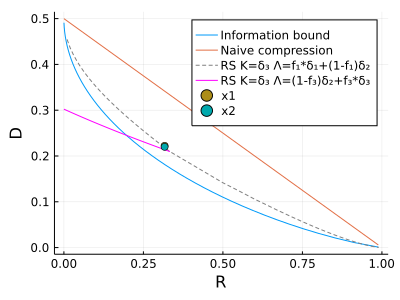

In [12]:
Rtrue = dim1/n
pl = plot_rdb()
scatter!(pl, [Rtrue], [dist1], label="x1")
scatter!(pl, [Rtrue], [dist2], label="x2")
plot(pl, size=(400,300))

### Find a path of small jumps
To find the expansion coefficients $\alpha$ of $x$ on the basis, solve $B\alpha=x$:
- Build $A=[B |x]$
- Reduce it with row operations to 
                                   |   | |
                                   | I |a|
                                   |___|_|
                                   | 0 |0|

In [157]:
B = BB1
A = ([B x])
A,dep = gfrrefGF2!(A)
dropzeros!(A)
alpha = A[dep,end]
@assert B*alpha.%2 == x
sum(alpha)

145

Build path from $0$ to $x$ by accumulating each small jump via a $\oplus$ operation

In [158]:
function build_path(B, alpha, x)
    n = length(x)
    nz_alpha = findall(alpha)
    P = falses(n,length(nz_alpha)+1)
    for (i,a) in enumerate(nz_alpha)
        P[:,i+1] .= xor.(P[:,i], B[:,a])
    end
    @assert P[:,end] == x
    P
end

build_path (generic function with 1 method)

In [159]:
# build path picking at each step the basis vector that gives the
#  lowest distortion wrt the source `y`
function build_lowdist_path(B, alpha, x, y)
    n = length(x)
    nz_alpha = findall(alpha)
    P = falses(n,length(nz_alpha)+1)
    for i in 1:length(nz_alpha)
        # pick next 
        j = argmin([sum(B[:,a].!=y) for a in nz_alpha])
        a = nz_alpha[j]
        P[:,i+1] .= xor.(P[:,i], B[:,a])
        deleteat!(nz_alpha, j)
    end
    @assert P[:,end] == x
    P
end

build_lowdist_path (generic function with 1 method)

In [160]:
# P = build_path(B, alpha, x)
P = build_lowdist_path(B, alpha, x, s.==-1)
weight_jumps = sum(P, dims=1)

1×146 Matrix{Int64}:
 0  75  172  201  224  217  218  236  …  351  331  316  315  309  287  243

### Observe the distortion

To go from path $P=(0,\dots,x)$ to $P_1=(x_1,\dots,x_2)$, just do $P_1=P\oplus x_1$

In [161]:
P1 = reduce(hcat, [xor.(P[:,i],x1) for i in 1:size(P,2)])
@assert P1[:,end]==x2

In [162]:
d = [distortion(s, 1 .- 2p) for p in eachcol(P1)]
boltz_weight = exp.(-d*HH);

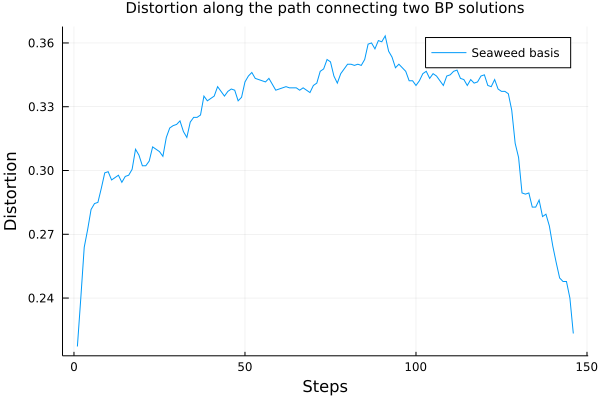

In [163]:
p1 = plot(d, label="Leaf-removal basis"); xlabel!("Steps"); ylabel!("Distortion")
title!("Distortion along the path connecting two BP solutions")
plot!(titlefontsize=10)

## Build the basis B using seaweeds

In [129]:
fg = FactorGraphGF2(Int.(H))
nsw = 5*fg.n
B, niters = seaweed_basis(nsw, fg, dim1)
println("Basis found after trying ", niters, " seaweeds")

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/0ub8y/src/ProgressMeter.jl:474
Progress:  20%|████████                                 |  ETA: 0:06:31
  iter:  1758
  dim:   606

Basis found after trying 1759 seaweeds


## Build path using the leaf-removal basis

In [164]:
A = ([BB1 x])
A,dep = gfrrefGF2!(A)
dropzeros!(A)
alpha = A[dep,end]
@assert BB1*alpha.%2 == x
sum(alpha)

76

In [165]:
# P = build_path(B, alpha, x)
PP = build_lowdist_path(BB1, alpha, x, s.==-1)
weight_jumps = sum(PP, dims=1)

1×77 Matrix{Int64}:
 0  9  13  19  27  22  29  46  67  82  …  250  248  250  242  249  244  243

### Observe the distortion

To go from path $P=(0,\dots,x)$ to $P_1=(x_1,\dots,x_2)$, just do $P_1=P\oplus x_1$

In [166]:
P2 = reduce(hcat, [xor.(PP[:,i],x1) for i in 1:size(PP,2)])
@assert P2[:,end]==x2

In [167]:
d2 = [distortion(s, 1 .- 2p) for p in eachcol(P2)]
boltz_weight = exp.(-d*HH);

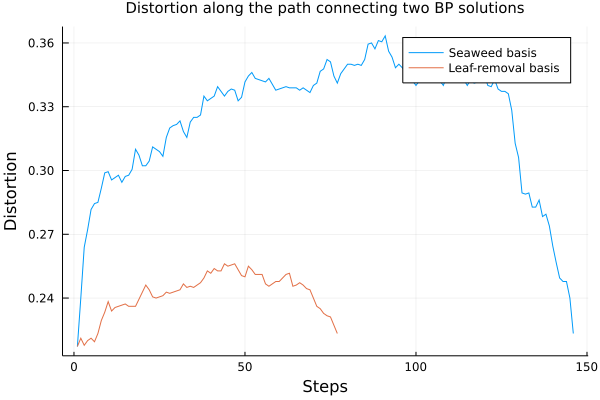

In [168]:
plot!(p1,d2, label="Leaf-removal basis"); xlabel!("Steps"); ylabel!("Distortion")
title!("Distortion along the path connecting two BP solutions")
plot!(titlefontsize=10)

In [169]:
maximum(d)

0.36333333333333334

In [170]:
sort(proportionmap(vec(sum(fg.H, dims=1))))

OrderedCollections.OrderedDict{Int64, Float64} with 4 entries:
  0 => 0.00888889
  1 => 0.143333
  2 => 0.698333
  3 => 0.149444